# C.3. Smart ETFs and Factor-Pricing Models
## Mark Hendricks - Discussion

# Prepare the Data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../cmds')
from portfolio import *

In [2]:
facs = pd.read_excel('../data/factor_pricing_data.xlsx',sheet_name='factors (excess returns)').set_index('Date')
assets = pd.read_excel('../data/factor_pricing_data.xlsx',sheet_name='portfolios (excess returns)').set_index('Date')

FREQ = 12

In [3]:
display(assets.tail())
display(facs.tail())

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-31,0.0629,0.0390,0.0183,0.0012,0.0048,0.0972,0.0355,0.0836,-0.0011,0.0419,...,0.0313,0.0687,0.0420,0.0595,0.0463,0.0925,-0.0101,0.1702,0.0968,0.0103
2024-01-31,-0.0500,-0.0201,-0.0119,-0.0129,-0.0298,-0.0610,0.0742,-0.0088,0.0330,-0.0563,...,-0.0167,-0.0203,0.0247,0.0092,0.0015,0.0109,0.0125,-0.0555,-0.0259,0.0408
2024-02-29,0.1574,-0.0134,0.0390,-0.0032,-0.0042,0.0328,0.0602,0.0107,0.0258,0.0556,...,0.0521,0.0807,0.0530,0.1040,0.0504,0.0362,0.0160,0.0425,0.0438,0.0667
2024-03-31,0.0737,0.0347,0.0156,0.0418,0.0473,0.0171,0.0063,-0.0088,0.0268,-0.0670,...,0.0574,0.0017,0.0398,0.0222,0.0045,0.0495,0.0359,0.0240,0.0429,0.0370
2024-04-30,-0.0629,0.0018,-0.0234,-0.0244,0.0199,-0.0367,-0.1011,-0.0632,-0.0205,-0.0686,...,-0.0352,-0.0885,-0.0639,-0.0556,-0.0279,-0.0437,-0.0456,-0.1186,-0.0500,-0.0285


,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
2023-12-31,0.0487,0.0732,0.0493,-0.0307,0.0132,-0.0551
2024-01-31,0.0070,-0.0574,-0.0238,0.0069,-0.0096,0.0511
2024-02-29,0.0506,-0.0078,-0.0349,-0.0199,-0.0214,0.0499
2024-03-31,0.0283,-0.0116,0.0419,0.0150,0.0117,-0.0041
2024-04-30,-0.0467,-0.0255,-0.0051,0.0147,-0.0030,-0.0051


# 2. Pricing Factor Stats

In [4]:
display(performanceMetrics(facs,annualization=12).style.format('{:.1%}'))

,Mean,Vol,Sharpe,Min,Max
MKT,8.5%,15.7%,53.8%,-23.2%,13.7%
SMB,0.8%,10.1%,8.1%,-15.3%,18.3%
HML,2.6%,11.0%,23.7%,-13.9%,12.8%
RMW,4.6%,8.3%,55.5%,-18.6%,13.1%
CMA,3.1%,7.3%,41.9%,-7.2%,9.1%
UMD,6.3%,15.5%,40.4%,-34.3%,18.2%


In [5]:
THRESH = .05
tailMetrics(facs,quantile=THRESH).style.format({
    'Skewness':'{:.2f}',
    'Kurtosis':'{:.2f}',
    'VaR (0.05)':'{:.1%}',
    'CVaR (0.05)':'{:.1%}',
    'Max Drawdown':'{:.1%}'
})

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
MKT,-0.66,1.97,-7.4%,-10.3%,-54.4%,2000-03-31 00:00:00,2009-02-28 00:00:00,2013-01-31 00:00:00,4689 days 00:00:00
SMB,0.33,4.00,-4.3%,-5.8%,-56.1%,1983-07-31 00:00:00,1999-03-31 00:00:00,2006-03-31 00:00:00,8279 days 00:00:00
HML,0.12,2.12,-4.2%,-6.9%,-58.4%,2006-12-31 00:00:00,2020-09-30 00:00:00,NaT,NaT
RMW,-0.37,10.70,-3.0%,-5.0%,-41.2%,1998-08-31 00:00:00,2000-02-29 00:00:00,2001-07-31 00:00:00,1065 days 00:00:00
CMA,0.31,1.60,-2.7%,-4.0%,-25.0%,2013-04-30 00:00:00,2020-10-31 00:00:00,2022-04-30 00:00:00,3287 days 00:00:00
UMD,-1.33,9.93,-6.8%,-10.9%,-57.6%,2008-11-30 00:00:00,2009-09-30 00:00:00,NaT,NaT


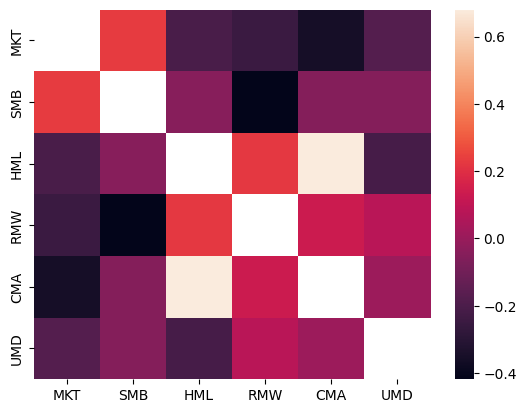

In [6]:
sns.heatmap(facs.corr().replace(1,np.nan));

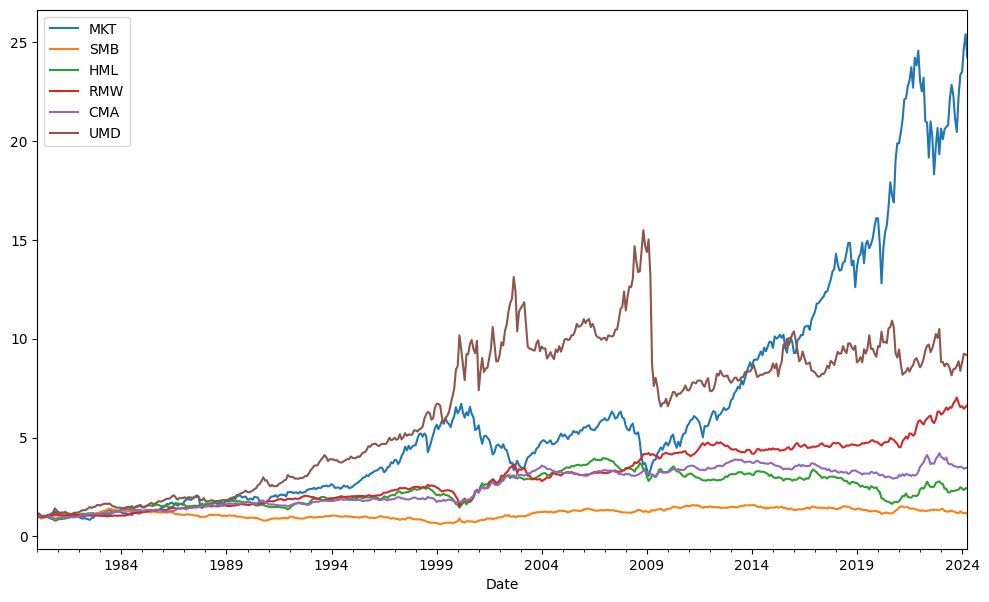

In [7]:
(facs+1).cumprod().plot(figsize=(12,7));

In [8]:
display(performanceMetrics(assets,annualization=12).style.format('{:.1%}'))

,Mean,Vol,Sharpe,Min,Max
Agric,8.8%,21.8%,40.4%,-29.7%,28.1%
Food,9.6%,15.1%,63.8%,-18.4%,18.7%
Soda,10.7%,22.0%,48.4%,-26.5%,38.6%
Beer,11.5%,17.0%,67.5%,-20.2%,21.7%
Smoke,13.0%,22.3%,58.3%,-25.4%,32.4%
Toys,5.9%,25.0%,23.5%,-35.1%,23.1%
Fun,11.7%,26.5%,44.2%,-32.5%,41.3%
Books,7.4%,20.7%,35.8%,-24.8%,30.6%
Hshld,8.0%,15.4%,52.3%,-22.3%,18.4%
Clths,9.5%,22.4%,42.3%,-31.4%,24.5%


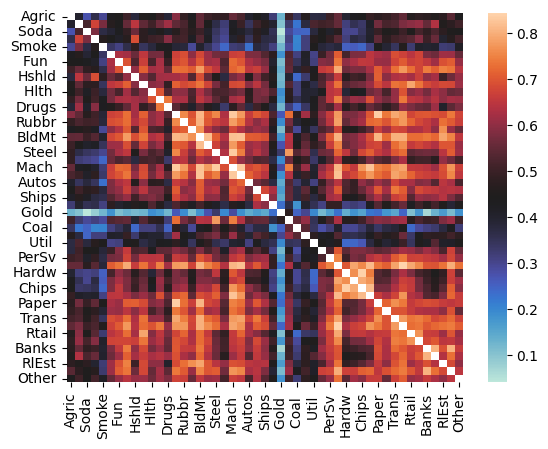

In [9]:
sns.heatmap((assets.corr()).replace(1,np.nan), cmap="icefire")
plt.show()

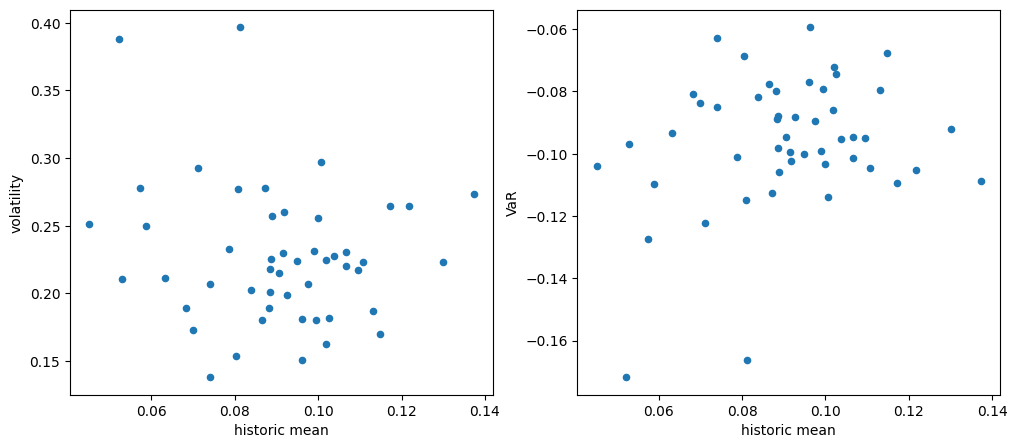

In [10]:
metrics = pd.DataFrame(assets.mean(),columns=['historic mean']) * FREQ
metrics['volatility'] = assets.std() * np.sqrt(FREQ)
metrics['VaR'] = assets.quantile(.05)

fig, ax = plt.subplots(1,2,figsize=(12,5))
metrics.plot.scatter(ax=ax[0], x='historic mean',y='volatility')
metrics.plot.scatter(ax=ax[1], x='historic mean',y='VaR')
plt.show()

# 2. CAPM

### Testing the model

In [11]:
regs_capm = get_ols_metrics(facs['MKT'],assets,annualization=FREQ)
display(regs_capm.style.format('{:.1%}'))

,alpha,MKT,r-squared,Treynor Ratio,Info Ratio
Agric,2.1%,79.9%,33.1%,11.1%,11.6%
Food,4.7%,58.4%,37.1%,16.5%,39.1%
Soda,4.7%,70.6%,25.4%,15.1%,24.7%
Beer,6.2%,62.7%,33.7%,18.3%,44.5%
Smoke,7.8%,61.8%,19.0%,21.0%,38.7%
Toys,-3.6%,112.0%,49.9%,5.2%,-20.4%
Fun,0.7%,130.4%,60.0%,9.0%,4.0%
Books,-1.6%,106.2%,65.3%,7.0%,-13.0%
Hshld,2.2%,68.7%,49.6%,11.7%,20.3%
Clths,0.4%,107.3%,56.7%,8.8%,2.7%


### Plot CAPM Fit

Plotting market beta against historic mean.

If CAPM fit, the scatter plot would (nearly) fit the line.

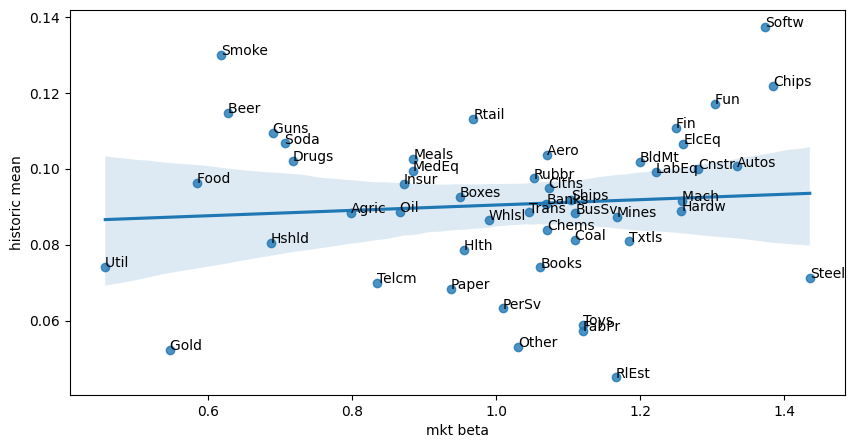

In [12]:
df = pd.DataFrame()
df['historic mean'] = assets.mean() * FREQ
df['mkt beta'] = regs_capm[['MKT']]
df.reset_index(inplace=True)

ax = sns.regplot(x='mkt beta',y='historic mean',data=df)
df[['mkt beta','historic mean','index']].apply(lambda x: ax.text(*x),axis=1);
plt.gcf().set_size_inches(10,5)
plt.show()

# 3. Multi-factor Models

### Testing the model

In [13]:
regs_facs = get_ols_metrics(facs,assets,annualization=FREQ)
display(regs_facs.style.format('{:.1%}'))

,alpha,MKT,SMB,HML,RMW,CMA,UMD,r-squared,Info Ratio
Agric,-0.3%,81.7%,37.2%,7.3%,18.4%,16.5%,6.4%,36.5%,-1.9%
Food,-0.2%,73.7%,-9.4%,-2.5%,48.7%,45.9%,1.5%,49.6%,-2.2%
Soda,0.6%,82.9%,-0.3%,0.2%,52.6%,44.0%,-11.2%,31.9%,3.1%
Beer,0.9%,78.6%,-11.8%,-18.2%,57.5%,48.7%,6.1%,45.1%,6.8%
Smoke,1.3%,82.9%,-11.7%,-11.4%,66.0%,82.2%,-7.6%,30.9%,6.9%
Toys,-5.4%,108.6%,60.1%,-19.8%,53.5%,26.7%,-18.2%,56.2%,-33.0%
Fun,3.1%,119.6%,30.0%,7.4%,2.6%,-23.6%,-21.7%,63.0%,19.3%
Books,-3.9%,108.9%,31.8%,18.5%,34.9%,11.1%,-9.1%,70.8%,-35.4%
Hshld,-1.9%,81.1%,-6.3%,-22.9%,49.3%,51.2%,-1.4%,59.1%,-19.8%
Clths,-2.2%,107.7%,41.8%,1.3%,75.8%,-0.0%,-21.0%,65.6%,-16.7%


## Comparison

### Not using any pricing model

In [14]:
unconditional_mean_all = assets.mean().mean()
alphas_none = (assets.mean()-unconditional_mean_all)

In [15]:
MAE = pd.DataFrame(index=['none','CAPM','Multi'],dtype=float,columns=['MAE']) 
MAE.loc['CAPM'] = regs_capm['alpha'].abs().mean() 
MAE.loc['Multi'] = regs_facs['alpha'].abs().mean()
MAE.loc['none'] = alphas_none.abs().mean() * FREQ
MAE.style.format('{:.1%}')

,MAE
none,1.5%
CAPM,2.0%
Multi,2.8%


# 4. Extras

## Factor Models and MV Efficiency

In [16]:
wts_tan_all = tangency_weights(assets.join(facs))
display(wts_tan_all.T.style.format('{:.1%}'))

wts_tan_facs = tangency_weights(facs)
display(wts_tan_facs.T.style.format('{:.1%}'))

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,Hlth,MedEq,Drugs,Chems,Rubbr,Txtls,BldMt,Cnstr,Steel,FabPr,Mach,ElcEq,Autos,Aero,Ships,Guns,Gold,Mines,Coal,Oil,Util,Telcm,PerSv,BusSv,Hardw,Softw,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other,MKT,SMB,HML,RMW,CMA,UMD
tangency weights,-0.5%,-0.5%,1.0%,1.4%,1.2%,-4.6%,3.2%,-2.3%,-3.2%,-0.7%,-2.0%,4.7%,5.3%,-1.8%,1.5%,-2.0%,-0.5%,-1.6%,-1.3%,0.1%,0.9%,1.9%,2.6%,1.6%,-1.8%,2.1%,0.3%,0.9%,-1.0%,-0.2%,4.3%,-1.3%,-7.3%,1.1%,-0.4%,7.8%,4.1%,1.4%,-4.7%,3.0%,0.6%,-5.4%,4.7%,-1.8%,-1.2%,3.2%,-5.0%,7.1%,-3.4%,0.7%,18.4%,8.0%,31.8%,25.1%,4.7%


,MKT,SMB,HML,RMW,CMA,UMD
tangency weights,20.9%,7.6%,-4.5%,30.9%,34.9%,10.3%


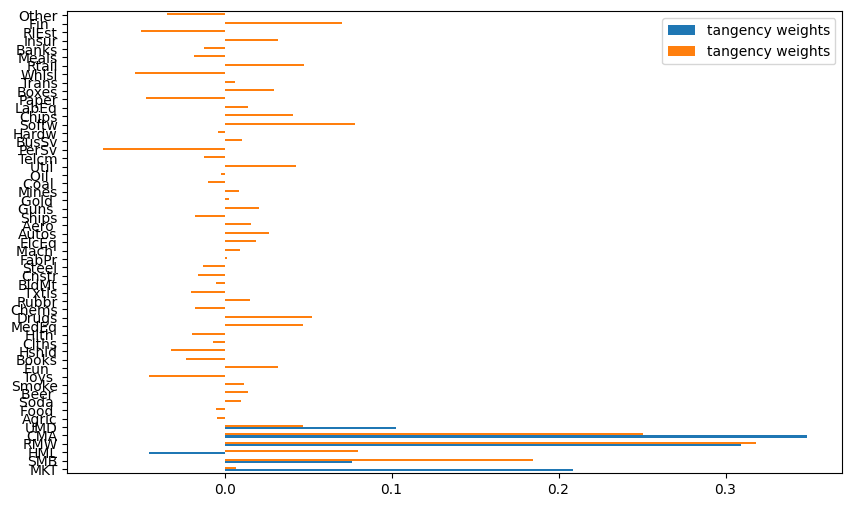

In [17]:
wts_tan = pd.concat([wts_tan_facs,wts_tan_all],axis=1)
wts_tan.plot.barh(figsize=(10,6));

## Testing Pricing Models with Cross-Sectional Regressions

Regress $\overline{r}^i$ on $\hat{\boldsymbol{\beta}^i}$ from the previous time-series regressions.

In [18]:
X = regs_facs[['MKT','SMB','HML','UMD']]
y = assets.mean()
reg_cs = sm.OLS(y,sm.add_constant(X)).fit()
print(reg_cs.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     4.908
Date:                Sat, 29 Jun 2024   Prob (F-statistic):            0.00232
Time:                        17:24:31   Log-Likelihood:                 253.70
No. Observations:                  49   AIC:                            -497.4
Df Residuals:                      44   BIC:                            -487.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.001      3.035      0.0

We see that the R-squared is much less than 1, which means the betas do not fully explain expected returns.

The estimated intercept is significant, so the factors do not explain all the expected returns.

The estimated factor premia for HML and SMB are **negative**! And it is the most statistically significant factor. This throws doubt on the idea that the value factor is a source of premium--maybe we should be considering the growth factor!

### Plotting multifactor models

Given that there are multiple factors, we can't plot a single beta against the historic mean returns.

Rather, we can use the cross-sectional regression to fit the model-expected-return and plot that against the historic mean returns.

If the model fit, all the points would line up on the 45-degree line, (one-for-one.) 

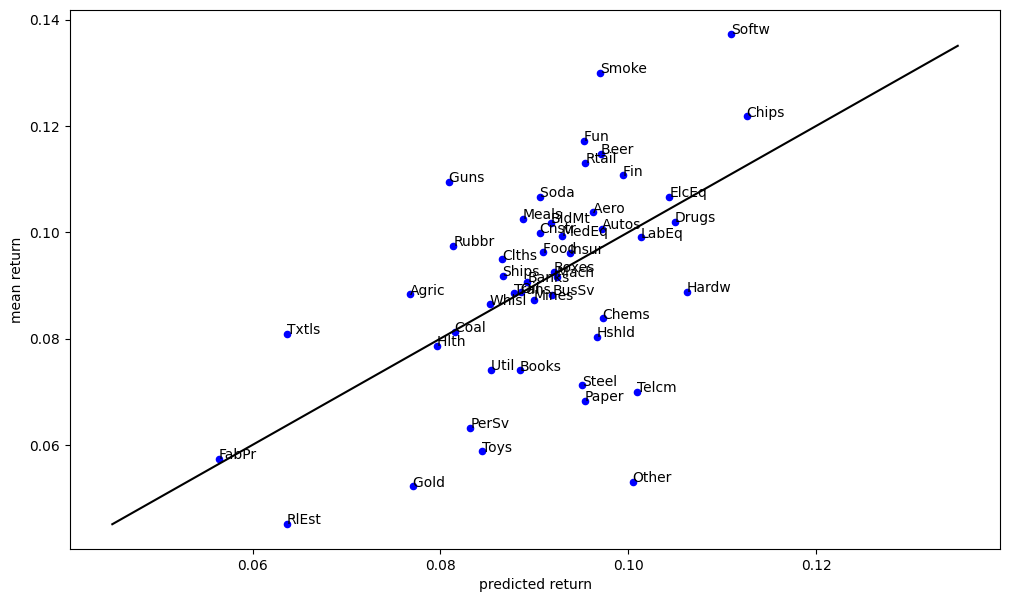

In [19]:
df = pd.DataFrame(columns=['mean return','predicted return'])
df['mean return'] = y 
df['predicted return'] = reg_cs.predict(sm.add_constant(X))
df *= FREQ

fig, ax = plt.subplots(figsize=(12,7)) 
df.plot(ax=ax, x='predicted return',y='mean return',kind='scatter',color='blue') 

y_line = np.arange(df.min().min(), df.max().max(), .005) 
x_line = y_line
ax.plot(y_line, x_line,color='k');

df.reset_index(inplace=True)
df[['predicted return','mean return','index']].apply(lambda x: ax.text(*x),axis=1);